## CS5344 Project 

Initial analyses. This notebook is split into two portions:

1) Part 1 scrapes twitter data from 4 companies: Telsa, Hyundai, Kia, and VW. Some companies - e.g. VW - have multiple accounts. We used the US account since it is in English, and US is a huge market of these 4 comapnies.

2) Part 2 performs basic descriptive analysis on the data. 

### 1) Scrapping

In [ ]:
import tweepy,csv,time,json,warnings

warnings.filterwarnings("ignore")

with open("config.json") as json_data_file:
    data = json.load(json_data_file)

# Fill in your own
access_token = data['access_token']
access_token_secret = data['access_token_secret']
api_key = data['api_key']
api_sec_key = data['api_sec_key']

In [ ]:
auth = tweepy.OAuthHandler(api_key, api_sec_key)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

# public_tweets = api.home_timeline()
# for tweet in public_tweets:
#     print(tweet.text)

test tweet for api access 2
test tweet for api access 1


In [ ]:
def makeCSV():
    with open('tweet_experiment/scrapped_tweets.csv','w') as f:
        writer = csv.writer(f)
        writer.writerow(["account","text","datetime", "favourite", "retweet", "reply_to_user"])

In [ ]:
accounts = ['tesla', 'kia', 'hyundai', 'VW']

In [ ]:
def verifyTwitterAccounts(accounts):
    print('Beginning verification of twitter accounts')
    currKeyID=0
    currentKey=accesstokenlist[currKeyID]
    auth = tweepy.auth.OAuthHandler(currentKey[0], currentKey[1])
    auth.set_access_token(currentKey[2], currentKey[3])
    api = tweepy.API(auth)
    error=False
    errorlist=[]
    for value in accounts:
        try:
            api.get_user(value)
        except:
            errorlist.append(value)
            error=True
    if error == True:
        print('Error: The following users are private/do not exist :' + str(errorlist))
    else:
        return "No errors"
    
verifyTwitterAccounts(accounts)

Beginning verification of twitter accounts


'No errors'

In [ ]:
def removeLinksAndLastCharacter(lst):
    lst=[lst[0]]+lst[2:]
    for i in range(1,len(lst)):
        text = lst[i][1]
        text=text.lower()
        x = text.find('http')
        while x != -1:
            text = lst[i][1][:x] + lst[i][1][x+22:]
            lst[i][1] = text
            x = text.find('http')
        lst[i][1]=lst[i][1][:-1]
        lst[i][1]=lst[i][1][2:]
    return lst

def updateAPIRate():
    x=api.rate_limit_status()
    rateID=x['resources']['statuses']['/statuses/user_timeline']['remaining']
    return rateID
    
def checkRateID():
    if rateID<=1:
        timeDifference = time.time() - timeStart
        if timeDifference > 0:
            print('RateID Exhausted, sleeping for rate reset. Key: '+str(account)) 
            time.sleep(905 - timeDifference)
            timeStart = time.time()

In [ ]:
makeCSV()
    
accounts = ['tesla', 'kia', 'hyundai', 'VW']
timeStart = time.time()

rateID = updateAPIRate()

for account in accounts:
    tic = time.time()
    print(f'Currently processing {account}')
    tweetlist = []
    oldest = None 
    
    while True:
        checkRateID()
        new_tweets = api.user_timeline(screen_name=account, count=200, max_id=oldest, tweet_mode="extended") 
        tweetlist.extend(new_tweets)
        if len(new_tweets) == 0: break
        oldest = new_tweets[-1].id - 1

    
    outtweets = [[account,
                  ''.join([i if ord(i) < 128 else '' for i in tweet.full_text.lower()]),
                  tweet.created_at, tweet.favorite_count, tweet.retweet_count,
                  tweet.in_reply_to_user_id] for tweet in tweetlist]
    
    with open('tweet_experiment/scrapped_tweets.csv', 'a',newline="") as f:
        writer = csv.writer(f)
        writer.writerows(outtweets)
    
    print(f'Took {time.time()-tic} seconds to process {account}')


with open('tweet_experiment/scrapped_tweets.csv','r') as f:
    reader = csv.reader(f)
    lst=list(reader)

tic = time.time()
lst = removeLinksAndLastCharacter(lst)

with open('tweet_experiment/scrapped_tweets_processed.csv','w',newline='') as f:
    writer = csv.writer(f)
    writer.writerows(lst)

Currently processing tesla
Took 35.39165019989014 seconds to process tesla
Currently processing kia
Took 36.107529640197754 seconds to process kia
Currently processing hyundai
Took 37.20808982849121 seconds to process hyundai
Currently processing VW
Took 35.79120230674744 seconds to process VW
Cleaning tweets
Took 0.011968135833740234 seconds to clean tweets


## 2) Initial analysis

Dictionary:
- `account`, `text`, `datetime`, `favourite`, `retweet` are fairly intuitive. 
- `reply_to_user` is an integer specifying the user account ID that the tweet was replying to. If it is not a reply, it will be `None`.

In [4]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt
df = pd.read_csv('tweet_experiment/scrapped_tweets_processed.csv')
df = df[~df['text'].isna()]

In [5]:
df.account.value_counts() # This is a limit set by twitter, not able to extract more than 3200 tweets per account

kia        3213
VW         3201
hyundai    3197
tesla      3171
Name: account, dtype: int64

In [8]:
df.head()

,account,text,datetime,favourite,retweet,reply_to_user,year,month,year_month
0,tesla,e tesla phone app to melt snow &amp; ice off y...,2021-03-01 18:02:10,97019,11056,NaN,2021,3,2021-03
1,tesla,del 3 earns top safety+ award from iihs for th...,2021-02-27 04:47:10,35382,2676,NaN,2021,2,2021-02
2,tesla,@elonmusk: @austinteslaclub the tesla solar r...,2021-02-22 20:23:49,0,2334,NaN,2021,2,2021-02
3,tesla,lar roof even clears off the sno,2021-02-21 21:03:24,63125,6286,NaN,2021,2,2021-02
4,tesla,aid winter testing,2021-02-19 20:21:28,27066,1957,NaN,2021,2,2021-02


### Insight 1: A higher proportion of Tesla's tweets are original tweets. 

- In contrast, for VW, Hyundai, Kia, a huge proportion of their tweets (~80%) are used to reply twitter users.
- An initial scan showed that among these replies, a significant percentage was to apologize to customers. 

In [ ]:
df['post'] = df['reply_to_user'].isna()
df.groupby('account')['post'].value_counts(normalize=True)

account  post 
VW       False    0.809747
         True     0.190253
hyundai  False    0.838911
         True     0.161089
kia      False    0.799253
         True     0.200747
tesla    True     0.529171
         False    0.470829
Name: post, dtype: float64

### Insight 2: A distinct proportion of replies are apologies

- Particularly so for Kia. 
- Almost none for Tesla (perhaps Tesla has another channel for this?)

In [ ]:
replies = df[df.post == False]
key_words = ['sorry', 'apologize', 'frustration', 'delay', 'concern', 'negative', 'feedback']
replies['apology_keywords_present'] = replies.apply(lambda row: any(word in row['text'] for word in key_words), axis=1)

In [ ]:
replies.groupby('account')['apology_keywords_present'].value_counts(normalize=True)

account  apology_keywords_present
VW       False                       0.732253
         True                        0.267747
hyundai  False                       0.937360
         True                        0.062640
kia      False                       0.504283
         True                        0.495717
tesla    False                       0.975887
         True                        0.024113
Name: apology_keywords_present, dtype: float64

### Insight 3: Intensity of tweets higher for VW, Hyundai and Kia 

- Since there is a limit of 3200 tweets per account, not surprising that coverage duration is shorter for VW, Hyundai and Kia.
- Even if we ignore replies, inetnsity of tweets still higher for Tesla's competitors.


In [6]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

df['datetime'] = pd.to_datetime(df.datetime)
df['year'] = df.datetime.dt.year
df['month'] = df.datetime.dt.month
df['year_month'] = df['datetime'].dt.to_period('M')

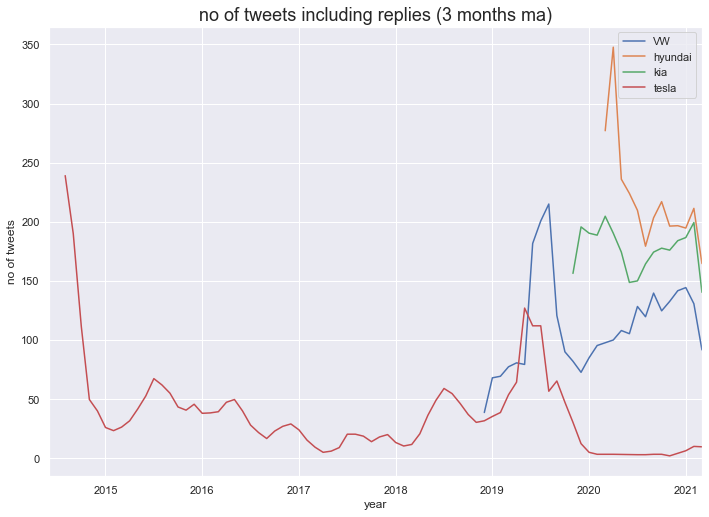

In [ ]:
te = df.groupby(['account', 'year_month']).agg('count')['text'].reset_index()
te['ma'] = te.groupby('account')['text'].rolling(window=3).mean().values 
te.set_index('year_month', inplace=True)
te.groupby('account')['ma'].plot(legend=True)
plt.xlabel('year')
plt.ylabel('no of tweets')
plt.title('no of tweets including replies (3 months ma)', fontsize=18)
plt.show()

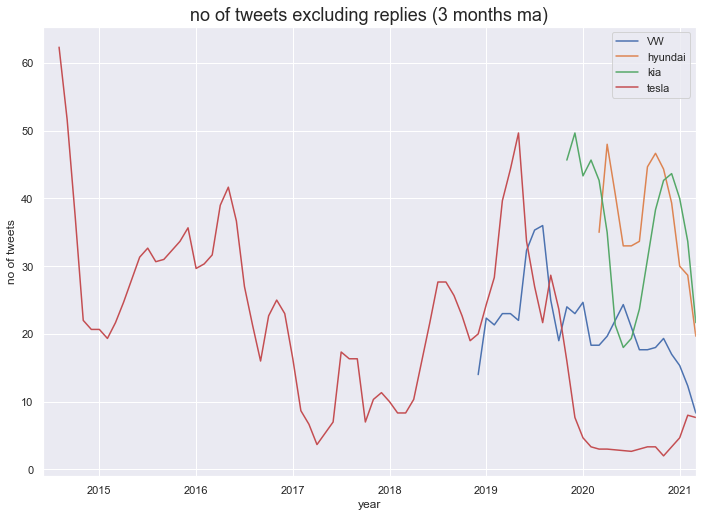

In [ ]:
te = df[df['reply_to_user'].isna()]
te = te.groupby(['account', 'year_month']).agg('count')['text'].reset_index()
te['ma'] = te.groupby('account')['text'].rolling(window=3).mean().values
te.set_index('year_month', inplace=True)
te.groupby('account')['ma'].plot(legend=True)
plt.xlabel('year')
plt.ylabel('no of tweets')
plt.title('no of tweets excluding replies (3 months ma)', fontsize=18)
plt.show()

## Insight 4: favourites & retweets

Tesla is far more popular than the rest 3 brands on Twitter. 

Tesla itself had the most number of favourites in 2019, while the most number of retweets in 2018. I think usually retweets show higher interactions than favourties? Then what are the reason here, maybe in 2018 and 2019 Tesla had different products?

Our data now is 2MB, too small size? Since in the pdf the prof says that hope to have large datasets. What else data can we extract?

In [20]:
fav_df = df.groupby(['account', 'year_month']).agg('sum')['favourite'].reset_index()

In [21]:
fav_df.head()

,account,year_month,favourite
0,VW,2018-10,93
1,VW,2018-11,2511
2,VW,2018-12,1926
3,VW,2019-01,1989
4,VW,2019-02,2489


In [22]:
fav_df2 = fav_df[fav_df['account']!='tesla']

In [ ]:
fav_df2.head()

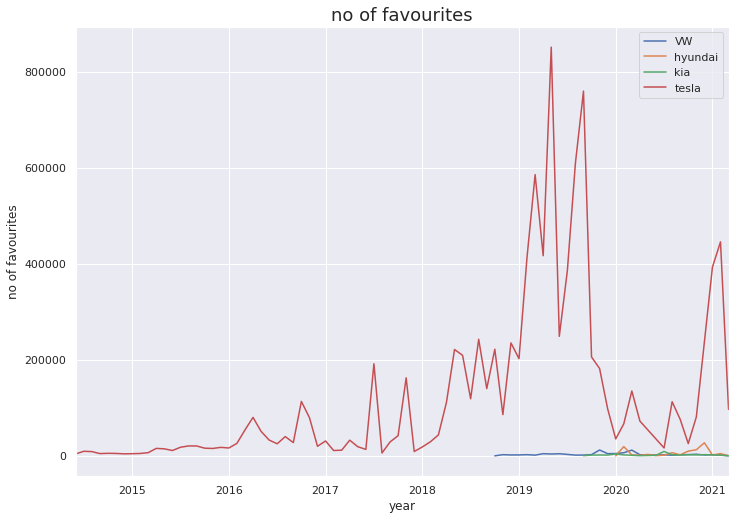

In [11]:
fav_df.set_index('year_month', inplace=True)
fav_df.groupby('account')['favourite'].plot(legend=True)
plt.xlabel('year')
plt.ylabel('no of favourites')
plt.title('no of favourites', fontsize=18) 
plt.show()

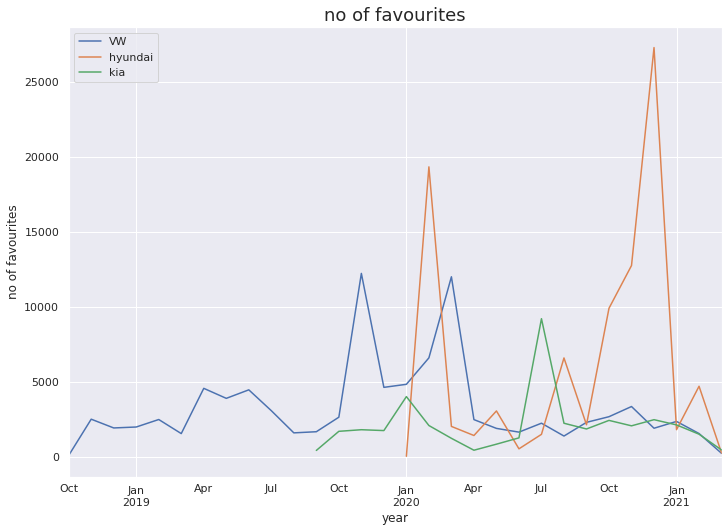

In [24]:
fav_df2.set_index('year_month', inplace=True)
fav_df2.groupby('account')['favourite'].plot(legend=True)
plt.xlabel('year')
plt.ylabel('no of favourites')
plt.title('no of favourites', fontsize=18) 
plt.show()

retweets:

In [25]:
retw_df = df.groupby(['account', 'year_month']).agg('sum')['retweet'].reset_index()

In [14]:
retw_df.head()

,account,year_month,retweet
0,VW,2018-10,16
1,VW,2018-11,638
2,VW,2018-12,458
3,VW,2019-01,518
4,VW,2019-02,527


In [26]:
retw_df2 = retw_df[retw_df['account']!='tesla']

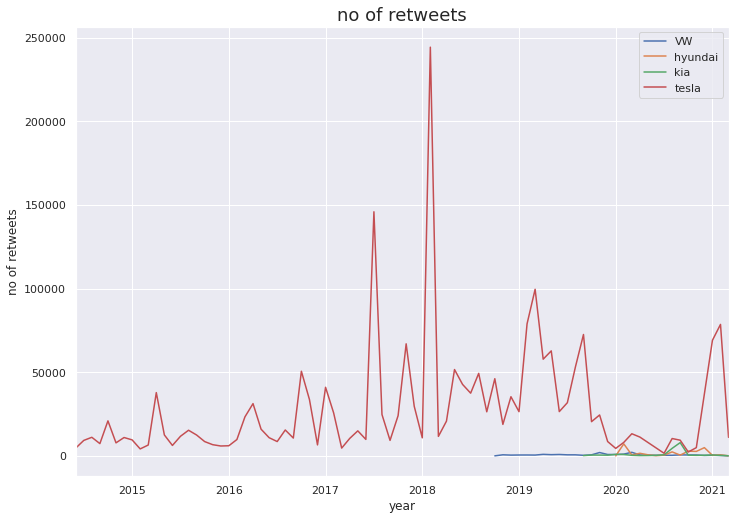

In [15]:
retw_df.set_index('year_month', inplace=True)
retw_df.groupby('account')['retweet'].plot(legend=True)
plt.xlabel('year')
plt.ylabel('no of retweets')
plt.title('no of retweets', fontsize=18) 
plt.show()

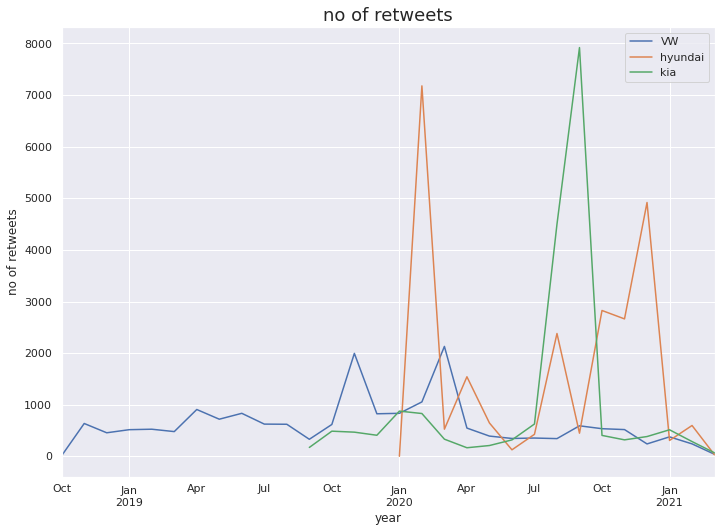

In [27]:
retw_df2.set_index('year_month', inplace=True)
retw_df2.groupby('account')['retweet'].plot(legend=True)
plt.xlabel('year')
plt.ylabel('no of retweets')
plt.title('no of retweets', fontsize=18) 
plt.show()